In [199]:
import sys 
sys.path.append("/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
sys.path.insert(1, '/cellar/users/mpagadal/Data/scripts')
import json

In [200]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import product
import seaborn as sns
import networkx as nx
from ndex2.nice_cx_network import NiceCXNetwork 
import ndex2.client as nc
import ndex2

In [201]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [202]:
from get_brian_rna import *

In [203]:
from upsetplot import generate_counts
from upsetplot import plot
from matplotlib import pyplot

## Make phenotype file for PLINK

In [204]:
def filter_zeros(df,threshold):
    '''
    inputs:
    df: dataframe of rna values
    threshold: % of zero values by which to exclude phenotypes
    
    output:
    dataframe with rna values < threshold of zero values
    '''
    
    keep=[]
    remove=[]
    
    for x in df.columns:
        if len(df[df[x]==0])>threshold*len(df):
            remove.append(x)
        else:
            keep.append(x)
    
    print("{} phenotypes with > {} zeroes were removed".format(len(remove),threshold))
    return(df[keep])
        

### Collect RNA phenotypes from TPM data

In [205]:
def brian_tpm_filter(lst,sample_type):
    #load brian's rna dataframe
    colnames = np.loadtxt('/cellar/users/btsui/Data/nrnb01_nobackup/Data/SRA/MATRIX/DATA/hgGRC38/TCGAmatrix.realign.gene.hgnc.columns.txt', dtype=str)
    rownames = np.loadtxt('/cellar/users/btsui/Data/nrnb01_nobackup/Data/SRA/MATRIX/DATA/hgGRC38/TCGAmatrix.realign.gene.hgnc.index.txt', dtype=str)
    tcga_df = pd.DataFrame(np.load('/cellar/users/btsui/Data/nrnb01_nobackup/Data/SRA/MATRIX/DATA/hgGRC38/TCGAmatrix.realign.gene.hgnc.npy'), index=rownames, columns=colnames)

    #get legacy mapping data
    legacy_df = pd.read_csv('/cellar/users/andreabc/Data/GDC_barcodes/LEGACY_uuid_barcode_map.txt', 
                        sep='\t', index_col='submitter_uuid')
    legacy_df = legacy_df.reset_index()
    legacy_df = legacy_df[legacy_df.submitter_uuid.notnull()] #get rid of null submitter uuid
    
    #filter dataframe for genes in list
    tcga_df.index=tcga_df.index.str.replace("-",".")
    filt = tcga_df.loc[tcga_df.index.isin(lst),:]
    filt =  filt.T
    
    #map ids to TCGA barcode
    dic = dict(zip(legacy_df.submitter_uuid, legacy_df.sample_barcode))
    filt.index=filt.index.map(dic)
    filt=filt[filt.index.notnull()]
    
    filt["code"]=filt.index.str.split("-").str[-1]
    filt.index=filt.index.str[0:12]
    
    if sample_type == "tumor":
        filt=filt[filt["code"].str.contains("01")]
        print(filt["code"].value_counts())
        del filt["code"]
        filt=filt.groupby(filt.index).mean()
    
    if sample_type == "normal":
        filt=filt[filt["code"].str.startswith("1")]
        print(filt["code"].value_counts())
        del filt["code"]
        filt=filt.groupby(filt.index).mean()

    return(filt)

In [206]:
def filter_genotyped(df,fam):
    #get genotyped patients
    geno=pd.read_csv(fam,header=None,sep=" ")[0].tolist()
    df=df[df.index.isin(geno)]
    df=df.reset_index()
    df=df.rename(columns={"index":"FID"})
    return(df)

In [207]:
pheno=pd.read_csv("../data/phenotype.mapping.csv",header=None)
pheno.head()

,0,1
0,ACE,antigen present
1,ACTR10,antigen present
2,ACTR1A,antigen present
3,ACTR1B,antigen present
4,AP1B1,antigen present


In [208]:
rna=brian_tpm_filter(pheno[0].tolist(),"tumor")

01A    9503
01B     200
01C      10
Name: code, dtype: int64


In [209]:
#filter out phenotypes with > 10% zero values
rna=filter_zeros(rna,0.1)

36 phenotypes with > 0.1 zeroes were removed


In [210]:
print(rna.shape)

(9561, 728)


In [211]:
rna=rna.reset_index().rename(columns={"index":"FID"})

### Collect CIBERSORTX data

In [212]:
ciber=pd.read_csv("/cellar/users/mpagadal/Data/cibersort/cibersortx-results/tcga/tpm_cibersortx_compiled_allsig.tsv",delimiter="\t")
ciber.columns=[x.replace(" ",".") for x in ciber.columns]
ciber=ciber.rename(columns={"Mixture":"FID"})
ciber=ciber.set_index("FID")

In [213]:
ciber=filter_zeros(ciber,0.1)

49 phenotypes with > 0.1 zeroes were removed


In [214]:
print(ciber.shape)

(9561, 12)


In [215]:
ciber=ciber.reset_index()

In [216]:
ciber.head()

,FID,LM22.T.cells.CD8,LM22.T.cells.follicular.helper,LM22.Macrophages.M2,NSCLC.Fig2ab.B.cells,dice.CD8_STIM,dice.M2,dice.TH1,dice.TH17,HNSCC.Fibroblast,HNSCC.Endothelial,melanoma.CAF,melanoma.Macrophages
0,TCGA-02-0047,0.001917,0.015500,0.324123,0.687473,0.043183,0.443866,0.069350,0.161311,0.498600,0.247231,0.302062,0.320460
1,TCGA-02-0055,0.031480,0.022601,0.289852,0.488191,0.062705,0.361803,0.072963,0.187417,0.666249,0.005093,0.704929,0.232990
2,TCGA-02-2483,0.034159,0.056436,0.468067,0.634741,0.096529,0.326827,0.054753,0.158911,0.392754,0.284847,0.262851,0.330924
3,TCGA-02-2485,0.007989,0.226252,0.294261,0.910478,0.112156,0.225340,0.069608,0.136810,0.439758,0.503177,0.225134,0.212266
4,TCGA-02-2486,0.135433,0.024709,0.426537,0.715499,0.030492,0.351950,0.150781,0.364722,0.671309,0.080076,0.311433,0.413945


### Collect Thorsson et al. immune state scores file

In [217]:
landscape=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/discovery/phenotypes/downloaded_phenos/pheno-immune-landscape-comp",delimiter="\t")
landscape=landscape.replace(-9, np.nan)
del landscape["IID"]
landscape.head()

,FID,Proliferation,Wound.Healing,Macrophage.Regulation,Lymphocyte.Infiltration.Signature.Score,IFN.gamma.Response,TGF.beta.Response
0,TCGA-01-0639,NaN,NaN,NaN,NaN,NaN,NaN
1,TCGA-02-0007,NaN,NaN,NaN,NaN,NaN,NaN
2,TCGA-02-0011,NaN,NaN,NaN,NaN,NaN,NaN
3,TCGA-02-0023,NaN,NaN,NaN,NaN,NaN,NaN
4,TCGA-02-0025,NaN,NaN,NaN,NaN,NaN,NaN


### Combine all immune phenotypes

In [218]:
total=pd.merge(rna,landscape,on=["FID"],how="outer")
total=pd.merge(total, ciber,on=["FID"],how="outer")
total=total.set_index("FID")

In [219]:
total = total.apply(pd.to_numeric,errors="coerce")

In [220]:
print(total.shape)
total.head()

(11206, 746)


,FGR,SEMA3F,DBNDD1,SLC25A5,CREBBP,WDR54,ITGA3,AP2B1,CX3CL1,TNFRSF12A,...,LM22.Macrophages.M2,NSCLC.Fig2ab.B.cells,dice.CD8_STIM,dice.M2,dice.TH1,dice.TH17,HNSCC.Fibroblast,HNSCC.Endothelial,melanoma.CAF,melanoma.Macrophages
FID,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047,10.462351,11.120751,64.943344,222.796921,19.143368,32.310970,68.991638,160.023560,76.170135,84.221405,...,0.324123,0.687473,0.043183,0.443866,0.069350,0.161311,0.498600,0.247231,0.302062,0.320460
TCGA-02-0055,12.997394,3.542931,12.078923,340.213165,8.614352,39.206337,61.047665,45.648369,25.906631,264.725098,...,0.289852,0.488191,0.062705,0.361803,0.072963,0.187417,0.666249,0.005093,0.704929,0.232990
TCGA-02-2483,9.448974,6.983698,18.041054,338.070496,13.141633,46.284431,24.381243,84.151978,20.013517,40.882793,...,0.468067,0.634741,0.096529,0.326827,0.054753,0.158911,0.392754,0.284847,0.262851,0.330924
TCGA-02-2485,7.011187,3.265420,29.600166,360.969116,19.037817,42.300026,7.119283,91.086723,20.380697,80.461861,...,0.294261,0.910478,0.112156,0.225340,0.069608,0.136810,0.439758,0.503177,0.225134,0.212266
TCGA-02-2486,13.871422,2.507942,12.292249,229.997849,4.587289,45.148750,146.060394,63.454029,10.426679,135.188126,...,0.426537,0.715499,0.030492,0.351950,0.150781,0.364722,0.671309,0.080076,0.311433,0.413945


### Filter for only genotyped patients

In [221]:
tcga_df=filter_genotyped(total,"/nrnb/users/mpagadal/tcga-genotypes/imputation/michigan-imputation/HRC/european.final.noimmunecancers.clean.fam")

In [222]:
print(tcga_df.shape)
tcga_df.head()

(8207, 747)


,FID,FGR,SEMA3F,DBNDD1,SLC25A5,CREBBP,WDR54,ITGA3,AP2B1,CX3CL1,...,LM22.Macrophages.M2,NSCLC.Fig2ab.B.cells,dice.CD8_STIM,dice.M2,dice.TH1,dice.TH17,HNSCC.Fibroblast,HNSCC.Endothelial,melanoma.CAF,melanoma.Macrophages
0,TCGA-02-0047,10.462351,11.120751,64.943344,222.796921,19.143368,32.310970,68.991638,160.023560,76.170135,...,0.324123,0.687473,0.043183,0.443866,0.069350,0.161311,0.498600,0.247231,0.302062,0.320460
1,TCGA-02-0055,12.997394,3.542931,12.078923,340.213165,8.614352,39.206337,61.047665,45.648369,25.906631,...,0.289852,0.488191,0.062705,0.361803,0.072963,0.187417,0.666249,0.005093,0.704929,0.232990
2,TCGA-02-2486,13.871422,2.507942,12.292249,229.997849,4.587289,45.148750,146.060394,63.454029,10.426679,...,0.426537,0.715499,0.030492,0.351950,0.150781,0.364722,0.671309,0.080076,0.311433,0.413945
3,TCGA-04-1332,1.587327,18.889095,21.084179,72.480659,20.600607,10.533038,26.183832,12.907973,23.363880,...,0.212655,0.839303,0.035891,0.206038,0.196037,0.486295,0.777307,0.186912,0.752511,0.131154
4,TCGA-04-1338,2.084633,6.618918,10.275887,80.976318,8.162801,14.475409,47.023655,12.441605,6.865872,...,0.192444,0.642535,0.069717,0.228317,0.114303,0.388767,0.731318,0.063031,0.735070,0.240005


## Submit cancer-specific phenos for rank normalization

In [223]:
canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
tcga_df["cancer"]=tcga_df["FID"].map(mp)

In [224]:
pheno_dir="/cellar/users/mpagadal/Data/projects/germline-immune/discovery/phenotypes/processed_phenos/tpm/tumor/"

In [225]:
for x in tcga_df["cancer"].unique():
    try:
        tumor=tcga_df[tcga_df["cancer"]==x]
        del tumor["cancer"]
        tumor.to_csv(pheno_dir+"pheno_"+x+".unnorm.csv",index=None,sep="\t")
    except:
        pass

In [226]:
compiled=pd.DataFrame()
for x in tcga_df["cancer"].unique().tolist():
    try:
        df=pd.read_csv(pheno_dir+"pheno_"+x+".rank.csv",delimiter="\t")
        df["cancer"]=x
        compiled=compiled.append(df)
    except:
        pass

### Confirm rank norm by cancer

Text(0.5, 1.0, 'FGR')

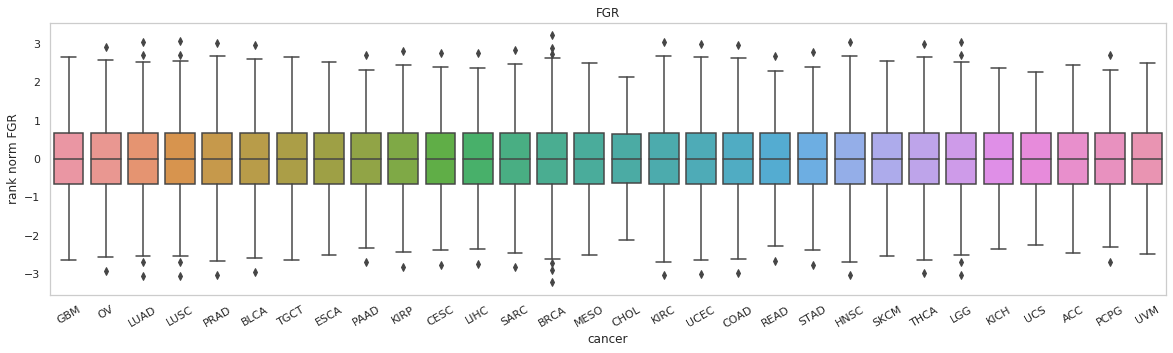

In [234]:
x="FGR"
#plot rna expression by cancer type
sns.set(style="whitegrid", font_scale = 1)
plt.figure(figsize=(20,5))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.boxplot(x="cancer", y=x, data=compiled)
ax.set(xlabel="cancer", ylabel='rank norm FGR')
plt.xticks(rotation=30)
plt.title(x)

In [235]:
del compiled["cancer"]
compiled["IID"]=compiled["FID"]
cols=["FID","IID"]+compiled.columns.tolist()[1:-1]
compiled=compiled[cols]
compiled.columns=[x.replace("-",".") for x in compiled.columns]
compiled=compiled.fillna(-9)

In [236]:
compiled.to_csv(pheno_dir+"pheno_all_zcancer",index=None,sep="\t")

In [237]:
print(compiled.shape)

(8207, 748)


## Get normal phenotype

In [172]:
rna=brian_tpm_filter(pheno[0].tolist(),"normal")

11A    714
11B     17
11C      1
Name: code, dtype: int64


In [173]:
rna=filter_zeros(rna,0.1)

33 phenotypes with > 0.1 zeroes were removed


In [174]:
print(rna.shape)

(731, 731)


In [175]:
tcga_df=filter_genotyped(rna,"/nrnb/users/mpagadal/tcga-genotypes/imputation/michigan-imputation/HRC/european.final.noimmunecancers.clean.fam")

In [177]:
tcga_df.head()

,FID,FGR,SEMA3F,DBNDD1,SLC25A5,CREBBP,WDR54,ITGA3,AP2B1,CX3CL1,...,DYNLL2,SEC22B,IKBKG,SPIB,CCL5,B2M,IFI27,LILRB2,PDCD1,LAIR1
0,TCGA-22-4593,52.741341,15.020543,4.582214,429.171570,9.122368,11.910508,160.098160,63.754631,27.899931,...,22.742100,16.280651,18.326183,1.704765,13.366350,1116.949951,9.388349,11.580532,0.684606,72.930031
1,TCGA-22-4609,33.633781,16.718197,3.968237,213.296768,24.401106,10.205466,140.817017,61.474487,171.599884,...,25.734800,16.778450,16.744671,1.920931,11.640704,1341.969971,31.000149,5.172295,1.269880,2.152551
2,TCGA-22-5471,44.874718,9.870248,7.872812,273.032104,16.605223,35.272629,170.285492,63.103294,58.130230,...,21.632900,13.636040,20.903175,0.799475,4.631590,882.776001,26.662445,3.884185,0.263936,37.160728
3,TCGA-22-5472,44.056370,20.890659,6.082714,254.809647,21.647938,21.475487,138.442764,89.757324,54.630062,...,28.040199,18.620789,17.859312,1.321082,7.909300,1024.579956,16.930290,11.225962,1.485900,26.772093
4,TCGA-22-5478,55.746078,20.647762,5.458734,235.072891,24.435022,13.300381,180.409561,76.275681,100.485710,...,27.382500,15.759120,19.987007,3.526640,14.037420,1105.920044,33.454338,10.710560,0.734698,29.996195


### Submit cancer-specific phenos for rank normalization

In [178]:
canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
tcga_df["cancer"]=tcga_df["FID"].map(mp)

In [179]:
pheno_dir="/cellar/users/mpagadal/Data/projects/germline-immune/discovery/phenotypes/processed_phenos/tpm/normal/"

In [180]:
for x in tcga_df["cancer"].unique():
    try:
        nml=tcga_df[tcga_df["cancer"]==x]
        del nml["cancer"]
        nml.to_csv(pheno_dir+"pheno_"+x+".unnorm.csv",index=None,sep="\t")
    except:
        pass
    

In [181]:
compiled=pd.DataFrame()
for x in tcga_df["cancer"].unique().tolist():
    try:
        df=pd.read_csv(pheno_dir+"pheno_"+x+".rank.csv",delimiter="\t")
        df["cancer"]=x
        compiled=compiled.append(df)
    except:
        pass

### Confirm rank norm

Text(0.5, 1.0, 'FGR')

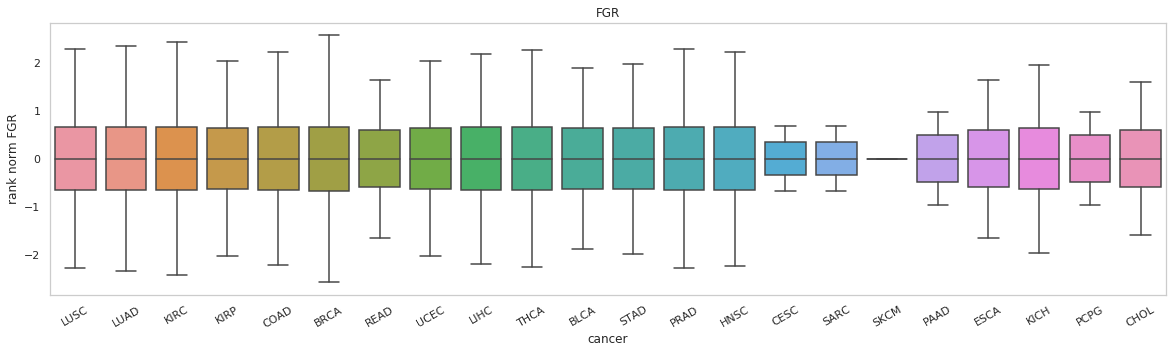

In [182]:
x="FGR"
#plot rna expression by cancer type
sns.set(style="whitegrid", font_scale = 1)
plt.figure(figsize=(20,5))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.boxplot(x="cancer", y=x, data=compiled)
ax.set(xlabel="cancer", ylabel='rank norm FGR')
plt.xticks(rotation=30)
plt.title(x)

In [183]:
del compiled["cancer"]
compiled["IID"]=compiled["FID"]
cols=["FID","IID"]+compiled.columns.tolist()[1:-1]
compiled=compiled[cols]
compiled.columns=[x.replace("-",".") for x in compiled.columns]
compiled=compiled.fillna(-9)

In [184]:
compiled.to_csv(pheno_dir+"pheno_all_zcancer",index=None,sep="\t")

## Confirm phenotypes are normally distributed

In [54]:
pheno=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/processed_phenos/brian-tpm/tumor/pheno_all_zcancer",delimiter="\t")


## Pearson correlation of phenos

We wanted to determine whether our phenotypes were strongly correlated or anti-correlated with each other.

In [55]:
del pheno["IID"]

In [56]:
pheno=pheno.replace(-9, np.nan)

In [57]:
pheno_corr=pheno.corr(method="pearson")

In [58]:
pheno_corr.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/immune-phenotype-pearson/brian.tpm.immune.phenotypes.pearson.csv")